In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset_path = "/content/drive/MyDrive/data.pkl"
print(dataset_path)

/content/drive/MyDrive/data.pkl


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)

Mounted at /content/drive


In [4]:
(train_imgs, train_labels), (test_imgs, test_labels) = data

train_imgs = train_imgs.astype('float32') / 255.0
test_imgs = test_imgs.astype('float32') / 255.0

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_imgs.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (1823, 256, 256, 3)
Training labels shape: (1823,)
Test images shape: (456, 256, 256, 3)
Test labels shape: (456,)


In [5]:
class_names =['Farhan', 'Hamim', 'Saad', 'Shishir']

In [6]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)

In [7]:
print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (1458, 256, 256, 3)
Training labels shape: (1458,)
Validation images shape: (365, 256, 256, 3)
Validation labels shape: (365,)


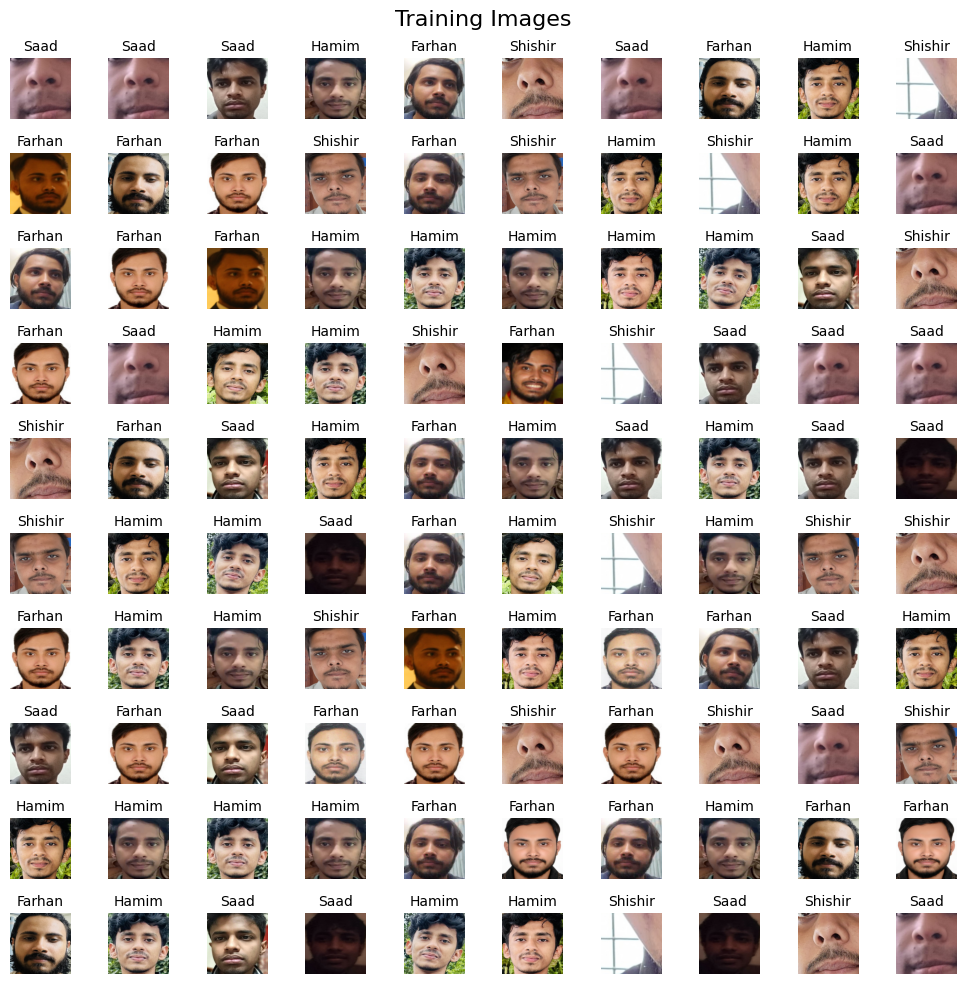

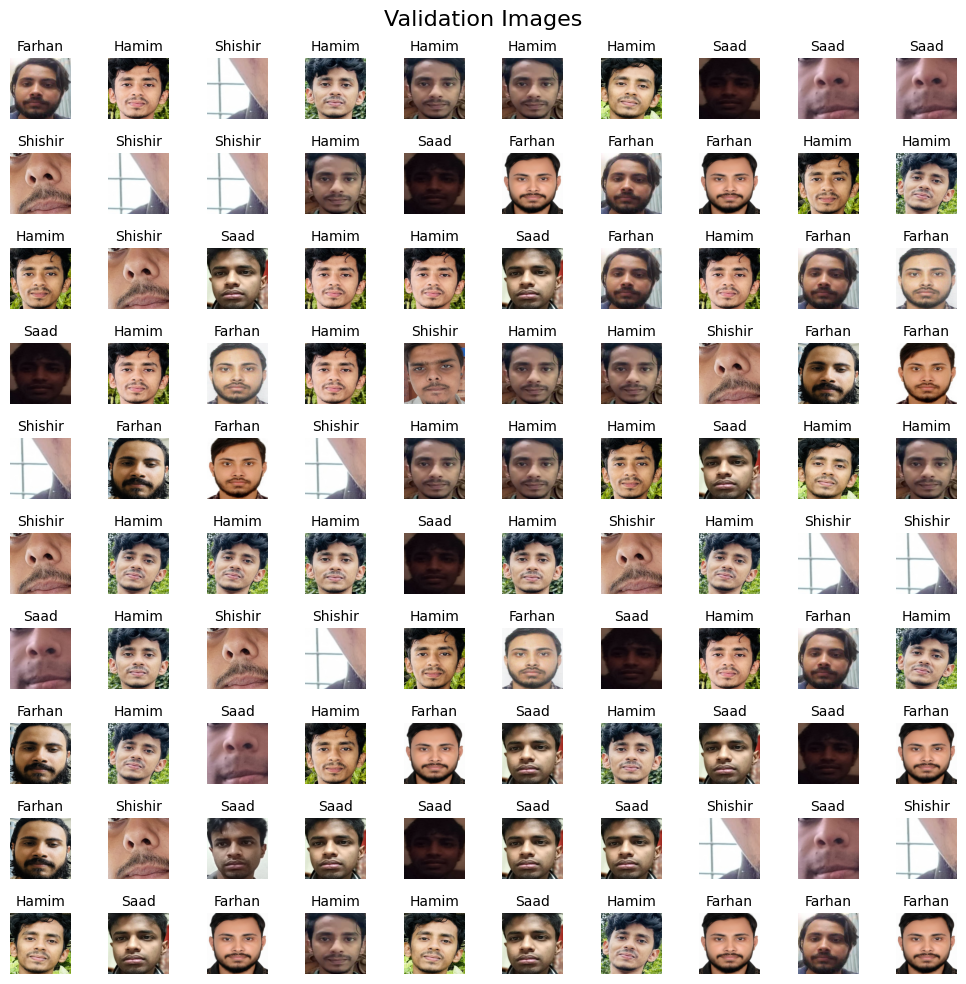

In [8]:
def plot_images(images, labels, title, class_names=None, num_images=100):
    grid_size = int(np.sqrt(num_images))

    # Select random images and labels
    idxs = np.random.choice(len(images), num_images, replace=False)
    selected_images = images[idxs]
    selected_labels = labels[idxs]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(selected_images[i])
        plt.axis('off')

        if class_names:
            plt.title(class_names[selected_labels[i]], fontsize=10)
        else:
            plt.title(selected_labels[i], fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_images(train_imgs, train_labels, title="Training Images", class_names=class_names)
plot_images(val_imgs, val_labels, title="Validation Images", class_names=class_names)

In [9]:
from tensorflow.keras import models, layers

model = models.Sequential([
    # Input Layer
    layers.Input(shape=(256, 256, 3)),

    # First Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten before Dense Layers
    layers.Flatten(),

    # Dense Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting

    # Output Layer
    layers.Dense(4, activation='softmax')  # 4 classes for groupmates
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,574,468 (128.08 MB)

 Trainable params: 33,574,468 (128.08 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_imgs)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    datagen.flow(train_imgs, train_labels, batch_size=12),
    epochs=50,
    validation_data=(val_imgs, val_labels),
    callbacks=[early_stopping],
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 36s 250ms/step - accuracy: 0.4601 - loss: 1.3639 - val_accuracy: 0.8137 - val_loss: 0.4087
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.7121 - loss: 0.6474 - val_accuracy: 1.0000 - val_loss: 0.2351
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.8133 - loss: 0.4660 - val_accuracy: 1.0000 - val_loss: 0.0708
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.9024 - loss: 0.3025 - val_accuracy: 1.0000 - val_loss: 0.0223
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.9167 - loss: 0.2313 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 204ms/step - accuracy: 0.9128 - loss: 0.2239 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.9539 - loss: 0.1456 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.9621 - loss: 0

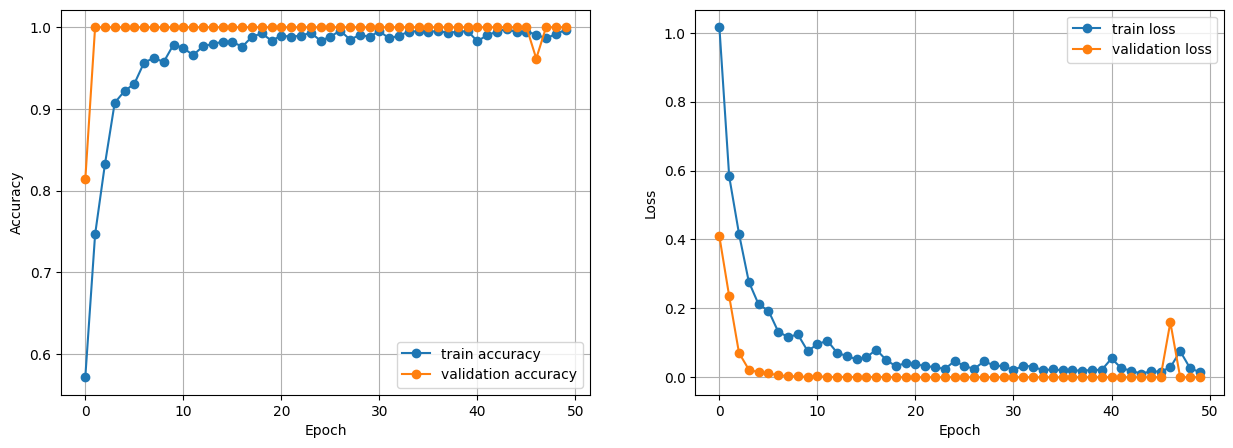

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_imgs, test_labels)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 5.2537e-07

Test Accuracy: 1.0

Test Loss: 4.914763280794432e-07


In [14]:
predictions = model.predict(test_imgs)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


In [15]:
model.save('face_recognition_model.keras')